# Part II: Model Building, Training and Testing

Now that we have a relatively tidy and balanced dataset of images, it is time to use them to train a classification model. We will be designing a Convolutional Neural Network to perform this task.

As CNNs require a lot of processing power to be trained, we will make use of the GPUs available through Google's colab service to complete this task. Therefore, there will be a couple of steps taken along the way to take care of that. In any case, our trained model can be stored and deployed in any machine, offline and without the need of GPUs.

In [1]:
# Dependencies: 

import os
from os import walk

import numpy as np
import librosa as lb
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow import keras

from google.colab import drive

## Loading audio data

In [ ]:
# This step is to mount Google drive on this notebook:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


With the Google Drive mounted, we can import our dataset to colab: 

In [2]:
TRAIN_DIR = '/content/drive/MyDrive/Training/Directory'
TEST_DIR = '/content/drive/MyDrive/Testing/Directory'

### Extract Features from Audio Data:

First let's define a short function to extract the features from the audio files. In this case, the features are the MFCCs calculated via librosa, and they are stored as numpy arrays. Normalization of each audio file between 0 and 1 will also help shape up more manageable features.

In [3]:
def get_MFCC(path):
    '''
    Extract MFCCs from audio file in path.
    '''
    # Load audio, default sample rate is 22050 Hz
    sound, sample_rate = lb.load(path)
    
    ''' 
    Normalize within range 0,1. The *if* statement is to avoid getting 
    *nan* values from blank files that have made it to the dataset.
    '''
    if np.max(sound) != np.min(sound):
        sound /= np.max(np.abs(sound))
    
    # Calculate MFCCs
    mfcc = lb.feature.mfcc(y=sound, sr=sample_rate)
    
    return mfcc

A function can be thus defined to calculate the MFCCs for all audio files in a directory and store them in an array:

In [4]:
def get_features(directory):

  filepaths = [] 

  for root, dirs, files in os.walk(directory):
    for name in files:
      filepaths.append(os.path.join(root,name))

  mfccs = []

  for i, filepath in enumerate(filepaths):
    mfccs.append(get_MFCC(filepath))
    if i % 10 == 0:
      print(i)

  mfccs = np.array(mfccs)

  return mfccs

Since the directories were arranged by label, we load the cough and non-cough audio separately. First we go through the cough .wav files to extract the MFCC features and stack them on an array *mfcc_0*.

We can see that we have 647 samples, and each MFCC has a size (20, 44). The latter translates to 20 ceptral coefficients and 44 frequency bins.

In [ ]:
mfcc_0 = get_features(TRAIN_DIR+'label_0/wav_0/')
np.save('mfccs_pos.npy', mfcc_0)
print(mfcc_0.shape)

(647, 20, 44)

Now we do the same to extract the features from the non-cough audio files.

In [6]:
mfcc_1 = get_features(TRAIN_DIR+'label_1/wav_1/')
np.save('mfccs_neg.npy', mfcc_1)
print(mfcc_1.shape)

(643, 20, 44)


The extracted feature arrays can be stored as .npy files, which can be loaded quickly and easily.

In [9]:
PATH_MFCC0 = '/content/drive/MyDrive/mfccs_pos.npy'
PATH_MFCC1 = '/content/drive/MyDrive/mfccs_neg.npy'

We can check on the feature arrays again:

In [10]:
mfcc_0 = np.load(PATH_MFCC0)
print('Shape of positives array: ', mfcc_0.shape)

mfcc_1 = np.load(PATH_MFCC1)
print('Shape of negatives array: ', mfcc_1.shape)

Shape of positives array:  (647, 20, 44)
Shape of negatives array:  (643, 20, 44)


### Format Input Data

Although we have all the features we need to train the model loaded up, we need to bring them in a format that can be sent to a tensorflow neural network. To do that, we concatenate the arrays corresponding to the two classes, and we also expand towards an extra singular dimension.

We also need to take care of the labels. Since we have loaded up the two classes separately, we can generate a label array simply by joining two arrays of zeros and ones with lengths corresponding to the number of samples in each class.

In [11]:
# Join classes:
X = np.concatenate((mfcc_0, mfcc_1))
# Expand dimension:
X = np.expand_dims(X, axis=-1)
print('Shape of input feature tensor: ', X.shape)

# Generate labels:
y_0 = np.zeros(mfcc_0.shape[0])
y_1 = np.ones(mfcc_1.shape[0])
# Join classes:
y = np.concatenate((y_0, y_1))
y = pd.Series(y, dtype=int)
# Arrange dimensionality:
y = pd.get_dummies(y).values
print('Shape of label tensor: ', y.shape)

Shape of input feature tensor:  (1290, 20, 44, 1)
Shape of label tensor:  (1290, 2)


## Convolutional Neural Network

Now that our data is ready, it is time to design the convolutional neural network architecture, and set our training parameters. We will use two 2D convolutional layers, with additional batch normalization and dropout layers to improve upon the training process. 
Notice the input size is the same as we defined for our data above, 20x40x1, and the output size is 2, corresponding to two classes, activated via a softmax function.

In [14]:
# Input stage
mfcc_input=keras.layers.Input(shape=(20,44,1), name = "mfccInput")

# 1st Convolution stage
x=keras.layers.Conv2D(32,3,strides=(1,1),padding='same', name = 'conv1')(mfcc_input)
x=keras.layers.BatchNormalization(name = 'bnorm1')(x)
x=keras.layers.Activation(keras.activations.relu, name = 'act1')(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid', name = 'pool1')(x)
x=keras.layers.Dropout(0.1, name='drop1')(x)

# 2nd Convolution stage
x=keras.layers.Conv2D(64,3,strides=(1,1),padding='same', name = 'conv2')(x)
x=keras.layers.BatchNormalization(name = 'bnorm2')(x)
x=keras.layers.Activation(keras.activations.relu, name = 'act2')(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid', name = 'pool2')(x)
x=keras.layers.Dropout(0.1, name='drop2')(x)

# Fully Connected stage
x=keras.layers.Flatten(name = 'flatten')(x)
x=keras.layers.Dense(units = 64, activation = 'relu', name = 'dense')(x)
x=keras.layers.Dropout(0.2, name='drop4')(x)

# Output stage
mfcc_output=keras.layers.Dense(2, activation='softmax', name = 'out')(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

Let's have a look at the summary of our model. 244,674 trainable parameters might seem a lot, but it's actually rather simple for a convolutional neural network.

In [15]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfccInput (InputLayer)       [(None, 20, 44, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 44, 32)        320       
_________________________________________________________________
bnorm1 (BatchNormalization)  (None, 20, 44, 32)        128       
_________________________________________________________________
act1 (Activation)            (None, 20, 44, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 10, 22, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 10, 22, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 22, 64)        18

Another visualization available through keras is direct image export:

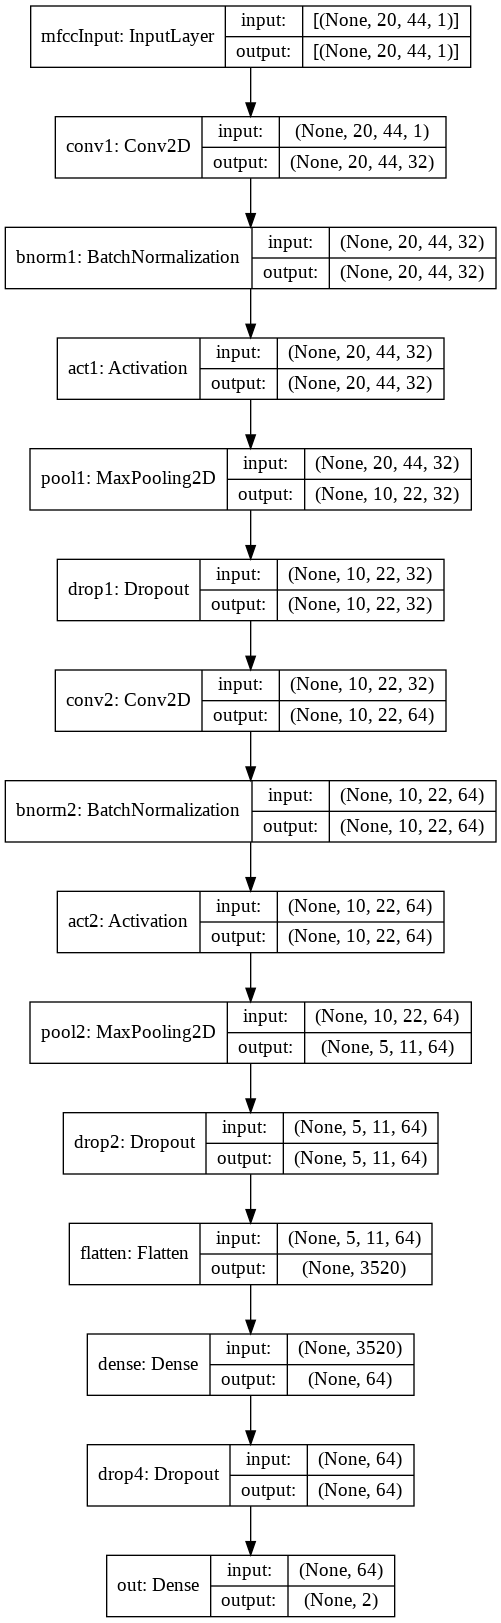

In [16]:
keras.utils.plot_model(mfcc_model, "net.png", show_shapes=True)

Now that the design is finalized, we will compile the model using *binary crossentropy* as loss, *accuracy* as the metric, and use the optimizer *adam* with a starting learning rate of 0.001. It is also useful to include a couple of callbacks so that the training becomes more efficient. We set an early stopping callback as well as a method to reduce the learning rate on plateaus of the loss function.

In [17]:
mfcc_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
keras.backend.set_value(mfcc_model.optimizer.learning_rate, 0.001)

my_callbacks = [keras.callbacks.EarlyStopping(patience=6),
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                patience=3, min_lr=0.00001,mode='min')]

### Model Training:

As we have all the data and labels the way we need them, we can split it into training and validation sets with the classic sklearn method.

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

The training can commence. Max number of epochs is set to 40, and batch size of 24 samples is used. The callbacks may be activated to stop the training early.

In [19]:
history=mfcc_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=50,
    verbose=1,
    batch_size=24,
    callbacks=my_callbacks
)

Epoch 1/50
43/43 [==============================] - 8s 12ms/step - loss: 1.1964 - accuracy: 0.5234 - val_loss: 0.7334 - val_accuracy: 0.4806
Epoch 2/50
43/43 [==============================] - 0s 4ms/step - loss: 0.4731 - accuracy: 0.8174 - val_loss: 1.6333 - val_accuracy: 0.4806
Epoch 3/50
43/43 [==============================] - 0s 4ms/step - loss: 0.2653 - accuracy: 0.9063 - val_loss: 1.1936 - val_accuracy: 0.4806
Epoch 4/50
43/43 [==============================] - 0s 4ms/step - loss: 0.1471 - accuracy: 0.9490 - val_loss: 0.7785 - val_accuracy: 0.4806
Epoch 5/50
43/43 [==============================] - 0s 4ms/step - loss: 0.1102 - accuracy: 0.9633 - val_loss: 0.5864 - val_accuracy: 0.6318
Epoch 6/50
43/43 [==============================] - 0s 4ms/step - loss: 0.1130 - accuracy: 0.9681 - val_loss: 0.4215 - val_accuracy: 0.9186
Epoch 7/50
43/43 [==============================] - 0s 4ms/step - loss: 0.0896 - accuracy: 0.9709 - val_loss: 0.4780 - val_accuracy: 0.6860
Epoch 8/50
43/43 [=

Training seems to have gone well. We reached a 97% validation accuracy during the final epoch, even higher than the training accuracy. Also the early stopping callback was activated, and training stopped at the 43rd epoch. We can visualize the process:

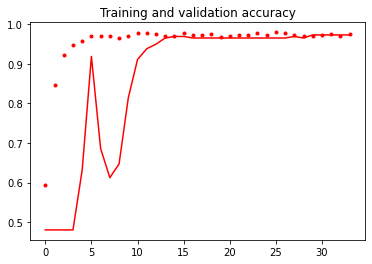

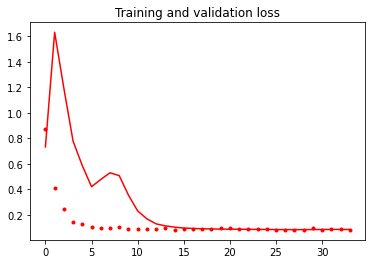

In [20]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)


We can notice irregularities early on. These are likely due to the effect of the Dropout layers, which shut off a number of neurons at each go during training to avoid overfitting.
Other than this, we have a standard trend of increasing accuracy and decreasing loss.

### Evaluate the Model on Test Data:

Finally we will evaluate our model using a small selection of test data never seen by the model during training. To make sure that these samples are completely new to our model, the coughing audio samples here are generated from entirely different clips than those used in the making of the training datasets, so we are introducing some entirely new 'voices' to our model.

Let's load and format our data like we did with the training case:

In [ ]:
mfcc_test = get_features(TEST_DIR+'/test/features')
y_test = np.load(TEST_DIR+'/test/labels')

In [23]:
# Expand dimensions to match correct input size:
X_test = np.expand_dims(mfcc_test, axis=-1)
print('Shape of test input feature tensor: ', X_test.shape)
print('Shape of test label tensor: ', y_test.shape)

Shape of test input feature tensor:  (52, 20, 44, 1)
Shape of test label tensor:  (52, 2)


And finally, time to evaluate the model on the test set using the evaluate function. We will print the loss and accuracy.

In [25]:
score, acc = mfcc_model.evaluate(X_test,
                                 y_test
                                 )
print('Test score:', score)
print('Test accuracy:', acc)

2/2 [==============================] - 0s 23ms/step - loss: 0.0612 - accuracy: 0.9808
Test score: 0.06124512478709221
Test accuracy: 0.9807692170143127


98% Accuracy was achieved. This is a pretty encouraging performance from a relatively simple and lightweight CNN, especially when we consider the lack of consistency between our coughing audio clips.

We can now store this trained model for deployment.

In [26]:
mfcc_model.save('/content/drive/MyDrive/Colab_Models/a_fitting_name_for_a_fit_model.h5')